

# <center>**ĐỒ ÁN 4 - KHOA HỌC MÁY TÍNH**</center>

---

# <center>**NGHIÊN CỨU KỸ THUẬT TRÍCH XUẤT ĐẶC TRƯNG TRONG NHẬN DẠNG VĂN BẢN**</center>


##**Giảng viên hướng dẫn: Ths Hà Lê Ngọc Dung**



---



##**Sinh viên thực hiện:** **Từ Thái Bảo MSSV 1900222**



#1. Import thư viện

In [ ]:
pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import string
import multiprocessing
import numpy as np
import pandas as pd
import keras
import gensim
import seaborn as sns
from tqdm import tqdm
from underthesea import word_tokenize
from sklearn import utils
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from pandas.plotting import scatter_matrix
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/KHMT0119/Data/UIT-VSFC.zip" -d "/content/"

Archive:  /content/drive/MyDrive/KHMT0119/Data/UIT-VSFC.zip
replace /content/_UIT-VSFC/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#2.  Load Dữ liệu

In [ ]:
train_path = '/content/_UIT-VSFC/train'
valid_path = '/content/_UIT-VSFC/dev'
test_path = '/content/_UIT-VSFC/test'

In [ ]:
def get_data(path):
    sents_file = open(os.path.join(path, 'sents.txt'), 'r')
    sentiments_file = open(os.path.join(path, 'sentiments.txt'), 'r')
    sents = sents_file.read()
    sentiments = sentiments_file.read()
    sents = sents.split('\n')
    sentiments = sentiments.split('\n')
    sentiments = [int(x) if x != '' else 0 for x in sentiments]
    df = pd.DataFrame(list(zip(sents, sentiments)), columns =['sentence', 'label'])
    return df

In [ ]:
train_df = get_data(train_path)
valid_df = get_data(valid_path)
test_df = get_data(test_path)

[Text(0.5, 1.0, 'Visualize data in column Labels')]

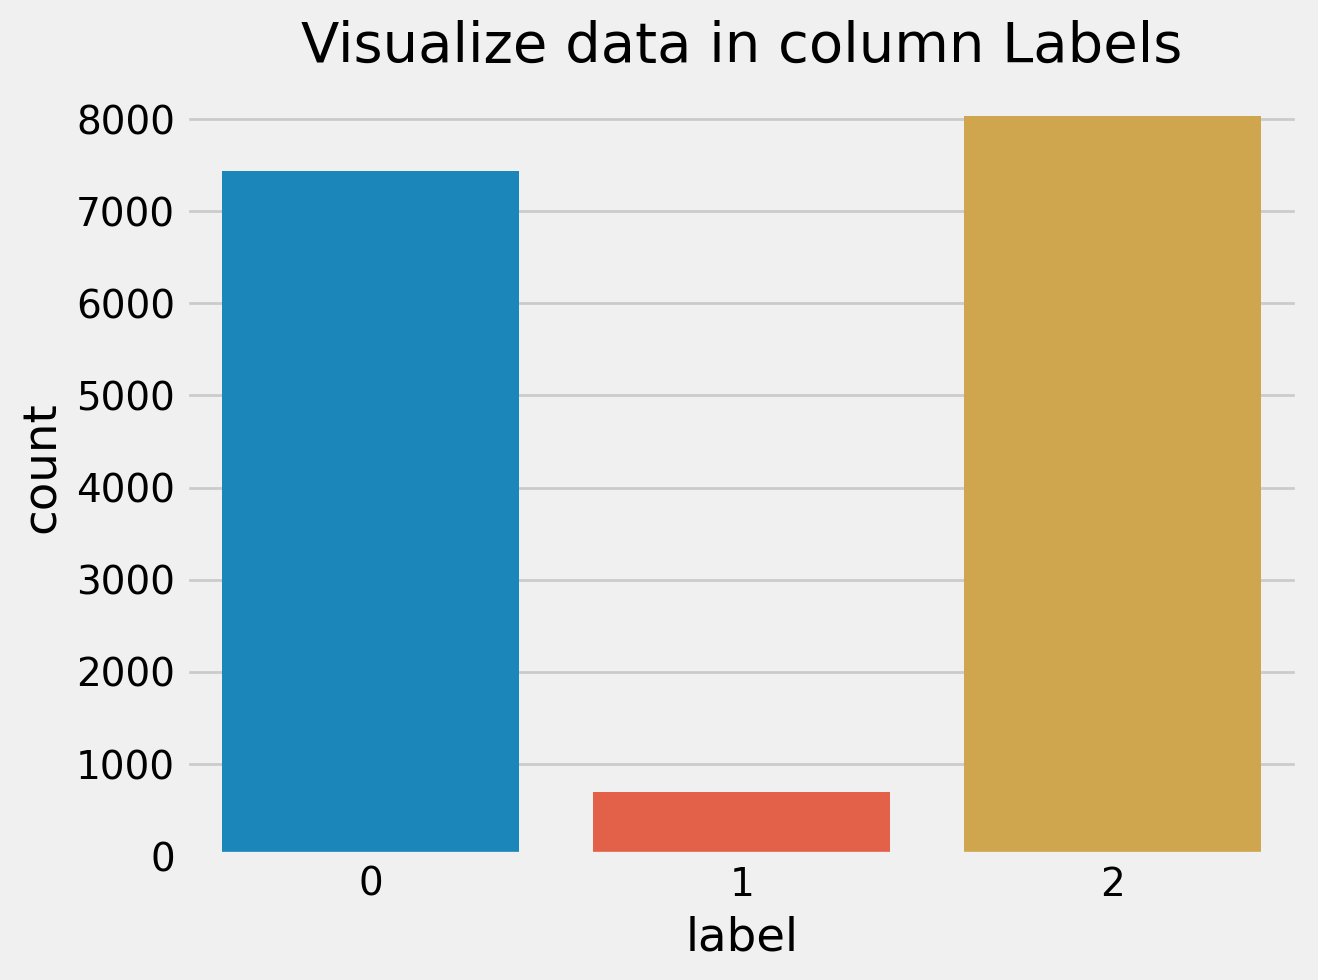

In [ ]:
df = pd.concat([train_df, valid_df,test_df])
sns.countplot(x='label', data=df).set(title='Visualize data in column Labels')

In [ ]:
train_df

,sentence,label
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2
...,...,...
11422,em cảm ơn cô nhiều .,2
11423,giao bài tập quá nhiều .,0
11424,"giáo viên dạy dễ hiểu , nhiệt tình .",2
11425,"gói gọn doubledot hay , tận tình , phù hợp với...",2


In [ ]:
def drop_index_df(df):
  id = df[df['label']==1]
  df.drop(id.index,inplace=True)
  df.reset_index(drop=True,inplace=True)
  df['label'] = df['label'].map({2:1,0:0})
  return df

In [ ]:
train_df = drop_index_df(train_df)
test_df = drop_index_df(test_df)
valid_df = drop_index_df(valid_df)

[Text(0.5, 1.0, 'Visualize data in column Labels drop 1')]

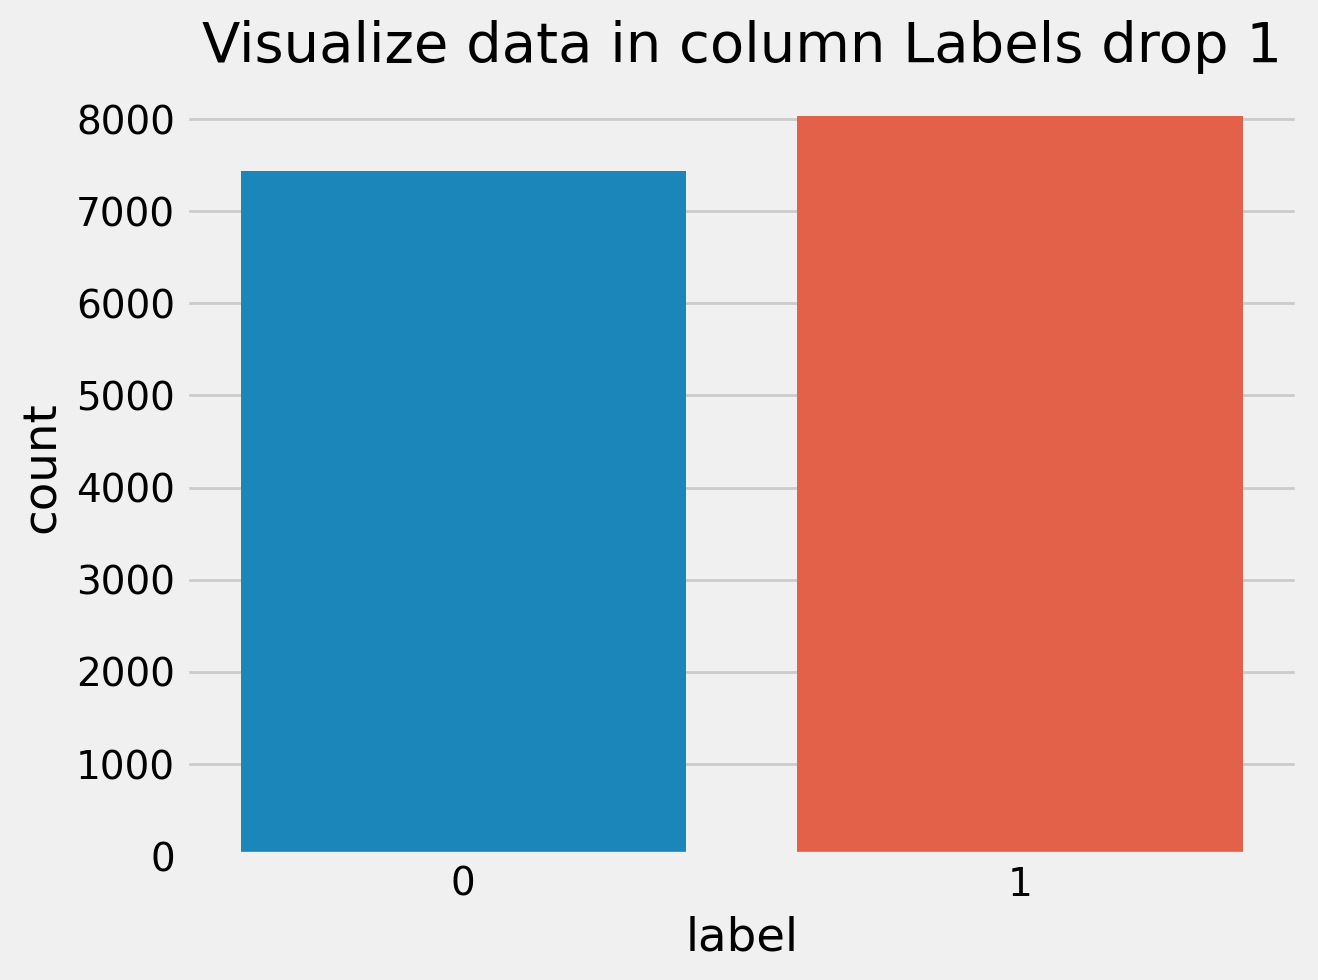

In [ ]:
df = pd.concat([train_df, valid_df, test_df])
sns.countplot(x='label', data=df).set(title='Visualize data in column Labels drop 1')

In [ ]:
train_df

,sentence,label
0,slide giáo trình đầy đủ .,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",1
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",1
...,...,...
10964,em cảm ơn cô nhiều .,1
10965,giao bài tập quá nhiều .,0
10966,"giáo viên dạy dễ hiểu , nhiệt tình .",1
10967,"gói gọn doubledot hay , tận tình , phù hợp với...",1


#3.  Tiền sử lý dữ liệu

In [ ]:
def cleaner(text):
    return text.translate(str.maketrans('','', string.punctuation))

def clean(df):
  clean = []
  for i in range(0,len(df)):
    clean.append(cleaner(df['sentence'][i]))
  return clean

In [ ]:
clean_train = clean(train_df)
clean_test = clean(test_df)
clean_valid = clean(valid_df)

## Tách từ

In [ ]:
tokenize_df=[]
for x in clean_train:
    tokenize_df.append(word_tokenize(x))

for x in clean_test:
    tokenize_df.append(word_tokenize(x))

for x in clean_valid:
    tokenize_df.append(word_tokenize(x))

In [ ]:
words=[]
for m in range(0,len(tokenize_df)):
    for n in range(0,len(tokenize_df[m])):
        words.append(tokenize_df[m][n])

In [ ]:
len(words)

149863

## Loại bỏ stopword

In [ ]:
filename = '/content/stopwords.csv'
data = pd.read_csv(filename,names=['word'])
list_stopwords = data['word']
myarray = np.asarray(list_stopwords)
def remove_stopword(text):
    text2=''
    for x in text:
        if x in myarray:
            text2+=""
        else:
            text2+=x+ " "
    return text2
storage=[]
for x in range(0,len(tokenize_df)):
    storage.append(remove_stopword(tokenize_df[x]))

## Tran, Test, VAL


In [ ]:
X_train = pd.Series(clean_train)
y_train = pd.Series(train_df['label'])

X_valid = pd.Series(clean_valid)
y_valid = pd.Series(valid_df['label'])

X_test = pd.Series(clean_test)
y_test = pd.Series(test_df['label'])

#4. Trích xuất đặt trưng

## 4.1 TF -IDF

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train)
X_train_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)

In [ ]:
print("Vector hoá tập Train TF-IDF ",X_train_tfidf.data)
print("------------------")
print("Kích thước vector ",X_train_tfidf.shape)

Vector hoá tập Train TF-IDF  [0.45295835 0.48467215 0.41156385 ... 0.26838392 0.25948468 0.20639552]
------------------
Kích thước vector  (10969, 2406)


## 4.2 CountVector

In [ ]:
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(X_train)

X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [ ]:
len(count_vect.get_feature_names_out())

2406

In [ ]:
print("Vector hoá tập Train BoW ",X_train_count.data)
print("------------------")
print("Kích thước vector ",X_train_count.shape)

Vector hoá tập Train BoW  [1 1 1 ... 1 1 1]
------------------
Kích thước vector  (10969, 2406)


## 4.3. Giảm chiều dữ liệu SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
SVD_TF = TruncatedSVD(n_components=1000, random_state=42)

SVD_TF.fit(X_train_tfidf)

TruncatedSVD(n_components=1000, random_state=42)

In [ ]:
X_train_tfidf_svd = SVD_TF.transform(X_train_tfidf)
X_test_tfidf_svd = SVD_TF.transform(X_test_tfidf)

In [ ]:
print("Kích thước vector TF- IDF ban đầu: ",X_train_tfidf.shape)
print("------------------")
print("Kích thước vector TF- IDF + SVD: ",X_train_tfidf_svd.shape)

Kích thước vector TF- IDF ban đầu:  (10969, 2406)
------------------
Kích thước vector TF- IDF + SVD:  (10969, 1000)


In [ ]:
SVD_BoW = TruncatedSVD(n_components=1000, random_state=42)

SVD_BoW.fit(X_train_count)

TruncatedSVD(n_components=1000, random_state=42)

In [ ]:
X_train_count_svd = SVD_BoW.transform(X_train_count)
X_test_count_svd = SVD_BoW.transform(X_test_count)

In [ ]:
print("Kích thước vector BoW ban đầu: ",X_train_count.shape)
print("------------------")
print("Kích thước vector BoW + SVD: ",X_train_count_svd.shape)

Kích thước vector BoW ban đầu:  (10969, 2406)
------------------
Kích thước vector BoW + SVD:  (10969, 1000)


## 4.4 World2Vec

In [ ]:
def labelize_text_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [ ]:
all_x = pd.concat([X_train,X_valid,X_test])
all_x_w2v = labelize_text_ug(all_x, 'all')

In [ ]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, vector_size=100, negative=5, window=2, min_count=2,
                         workers=cores, alpha=0.065, min_alpha=0.065)

In [ ]:
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 15480/15480 [00:00<00:00, 1191642.37it/s]


In [ ]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 15480/15480 [00:00<00:00, 1468988.57it/s]


CPU times: user 9.13 s, sys: 87.5 ms, total: 9.22 s
Wall time: 7.6 s


In [ ]:
model_ug_sg = Word2Vec(sg=1, vector_size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 15480/15480 [00:00<00:00, 1771419.14it/s]


In [ ]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 15480/15480 [00:00<00:00, 1734415.01it/s]


CPU times: user 15.2 s, sys: 112 ms, total: 15.3 s
Wall time: 9.17 s


In [ ]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

###Get Keyed Vectors

In [ ]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [ ]:
model_ug_cbow.wv.most_similar("cô")

[('thầy', 0.8533012270927429),
 ('viên', 0.4070911109447479),
 ('nhảm', 0.3583439886569977),
 ('dẽ', 0.3409343361854553),
 ('giảng', 0.3180447518825531),
 ('colonhihi', 0.312735915184021),
 ('hay', 0.3040904700756073),
 ('tui', 0.30101197957992554),
 ('thày', 0.2902674973011017),
 ('tậm', 0.27986642718315125)]

In [ ]:
model_ug_sg.wv.most_similar("cô")

[('thầy', 0.8489344120025635),
 ('colonhihi', 0.5240405201911926),
 ('tánh', 0.5238497257232666),
 ('thày', 0.49643442034721375),
 ('viên', 0.49094298481941223),
 ('ơ', 0.4854833483695984),
 ('giảng', 0.4782792031764984),
 ('tui', 0.4650914967060089),
 ('hảo', 0.4584912955760956),
 ('truyển', 0.4520215094089508)]

## Appending cbow and sg


In [ ]:
embeddings_index = {}
for w in list(model_ug_cbow.wv.index_to_key):
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 1670 word vectors.


#Vectorize Word2Vec (float)

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~ ')
tokenizer.fit_on_texts(X_train)

In [ ]:
len(tokenizer.word_index)

2431

In [ ]:
sequences_digit = tokenizer.texts_to_sequences(X_train)

Lấy độ dài tối đa của vector (lý do của tất cả đầu vào phải có cùng kích thước với ma trận)

In [ ]:
length = []
for x in X_train:
    length.append(len(x.split()))
max(length)

147

In [ ]:
x_train_seq = pad_sequences(sequences_digit, maxlen=150)
print('Shape of train data tensor:', x_train_seq.shape)

sequences_val = tokenizer.texts_to_sequences(X_valid)
x_val_seq = pad_sequences(sequences_val, maxlen=150)
print('Shape of valid data tensor:', x_val_seq.shape)

sequences_test = tokenizer.texts_to_sequences(X_test)
x_test_seq = pad_sequences(sequences_test, maxlen=150)
print('Shape of test data tensor:', x_test_seq.shape)

Shape of train data tensor: (10969, 150)
Shape of valid data tensor: (1511, 150)
Shape of test data tensor: (3000, 150)


In [ ]:
num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
np.array_equal(embedding_matrix[116] ,embeddings_index.get('slide'))

True

In [ ]:
embedding_matrix[116]

array([-0.16328688, -0.26320317, -0.72478414,  0.38470176, -0.05059852,
       -1.90340865,  0.42926443,  0.26114863, -0.3971546 ,  0.26754642,
       -0.34740579, -1.00941813,  0.78222829, -0.23659495, -0.00705804,
        0.40474349,  0.26459235, -1.11907721, -0.86639214,  0.22041641,
        0.79953694, -0.57667905, -1.02022815, -0.96629286, -0.66322786,
        0.04451365,  0.49192482, -2.49466085,  1.20188558, -0.67419237,
       -1.65109146,  0.17311594, -0.42421636,  0.35767797,  1.0628711 ,
        0.70450711, -1.33562481,  0.42104909, -0.12909165,  0.38411191,
       -0.4344511 , -0.45704353, -1.68078446, -2.47045636,  0.81205606,
        0.1884701 ,  0.14376223, -0.16895528, -0.98627847, -0.45260251,
       -0.11517934,  0.41087946, -0.29566297, -0.24505626, -0.26893261,
        0.85337442, -0.52405602, -1.00717235, -1.2568512 ,  0.25039732,
       -0.94310999, -0.89035553, -0.51527876, -0.84800303,  1.16468477,
        0.24484028,  1.54529071,  0.1069909 ,  1.04061198, -1.47

In [ ]:
embeddings_index.get('cô')

array([-0.26487407,  0.60600215, -0.06360736, -0.89552695, -0.12429574,
       -0.94020045,  1.0027457 , -0.184559  ,  0.40561506,  0.01079717,
        0.157261  ,  0.06438657,  0.08067759, -0.05668892,  0.31332174,
       -0.3638727 ,  0.4768669 , -0.8598308 , -0.40544608,  0.47504815,
       -0.01488723,  0.33079553,  0.26217094,  0.62526953, -0.15654276,
       -0.06668741, -0.45004448, -0.3587115 ,  0.52013075,  0.8149693 ,
       -0.18035851,  0.26531437, -0.777629  , -1.9271775 , -0.1030955 ,
        1.652384  , -0.18546987,  0.651049  , -0.3566442 ,  0.28472343,
        0.6290634 , -0.5980699 ,  0.09047644,  0.54789895, -0.7260056 ,
        0.48754048,  0.08457   , -0.6376397 , -0.67374164, -0.40908366,
        0.51471764, -0.0455816 , -1.0442833 , -0.4766699 ,  0.53315276,
        0.8838948 ,  0.03563728, -0.27075085, -0.3350906 ,  0.39689797,
        0.28985217, -0.12473142, -0.11497167, -0.07402338,  0.8118924 ,
       -0.26867497,  0.29908583, -0.21989766, -1.2098755 , -0.32

In [ ]:
print("Kích thước vector Word2Vec", embeddings_index.get('cô').shape)

Kích thước vector Word2Vec (200,)


#Validating on DataSet - Dev

In [ ]:
from keras.utils.np_utils import to_categorical

labels_train = to_categorical(train_df.label, num_classes=2)
labels_test = to_categorical(test_df.label, num_classes=2)
labels_dev = to_categorical(valid_df.label, num_classes=2)

# SVM

###SVM - TF IDF

In [ ]:
from sklearn.model_selection import GridSearchCV

# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}

# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# # fitting the model for grid search
# grid.fit(X_train_tfidf,y_train)
# # print best parameter after tuning
# print(grid.best_params_)

# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)

In [ ]:
model_Tf = SVC(C=1, kernel='rbf', gamma=1)
SVM_Tf_Idf = model_Tf.fit(X_train_tfidf_svd,y_train)

In [ ]:
y_pred_SVM = SVM_Tf_Idf.predict(X_test_tfidf_svd[19:20])
y_pred_SVM

array([1])

In [ ]:
y_pred_SVM = SVM_Tf_Idf.predict(X_test_tfidf_svd)
a = accuracy_score(y_pred_SVM, y_test)
print("Validation accuracy: ", a*100)

Validation accuracy:  93.56666666666666


In [ ]:
f1_score(y_test, y_pred_SVM, average='macro')

0.9356264331874087

In [ ]:
a= classification_report(y_test, y_pred_SVM, target_names = ["0", "1"])
print(a)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1410
           1       0.97      0.91      0.94      1590

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



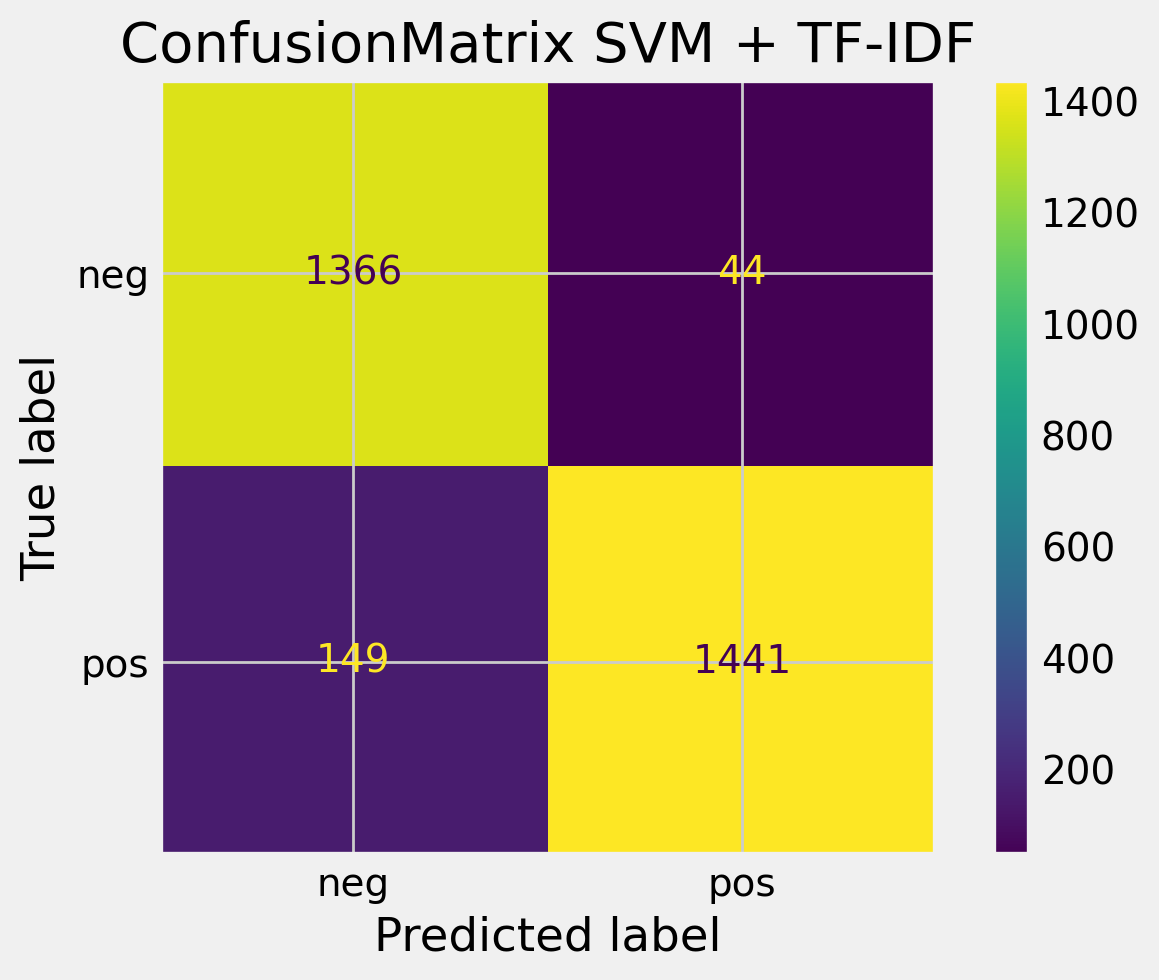

In [ ]:
cm = confusion_matrix(y_test, y_pred_SVM, labels=SVM_Tf_Idf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['neg', 'pos'])
disp.plot()
plt.title('ConfusionMatrix SVM + TF-IDF')
plt.show()

###SVM - BOW

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}

# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# # fitting the model for grid search
# grid.fit(X_train_count_svd,y_train)
# # print best parameter after tuning
# print(grid.best_params_)

# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)

In [ ]:
model_Bow = SVC(C=10, kernel='rbf', gamma=0.01)
# {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# SVC(C=10, gamma=0.01)
SVM_BoW =model_Bow.fit(X_train_count_svd,y_train)

In [ ]:
y_pred_SVM_count = SVM_BoW.predict(X_test_count_svd)
a = accuracy_score(y_pred_SVM_count, y_test)
print("Validation accuracy: ", a*100)

Validation accuracy:  93.30000000000001


In [ ]:
a= classification_report(y_test, y_pred_SVM_count, target_names = ["0", "1"])
print(a)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1410
           1       0.95      0.92      0.94      1590

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



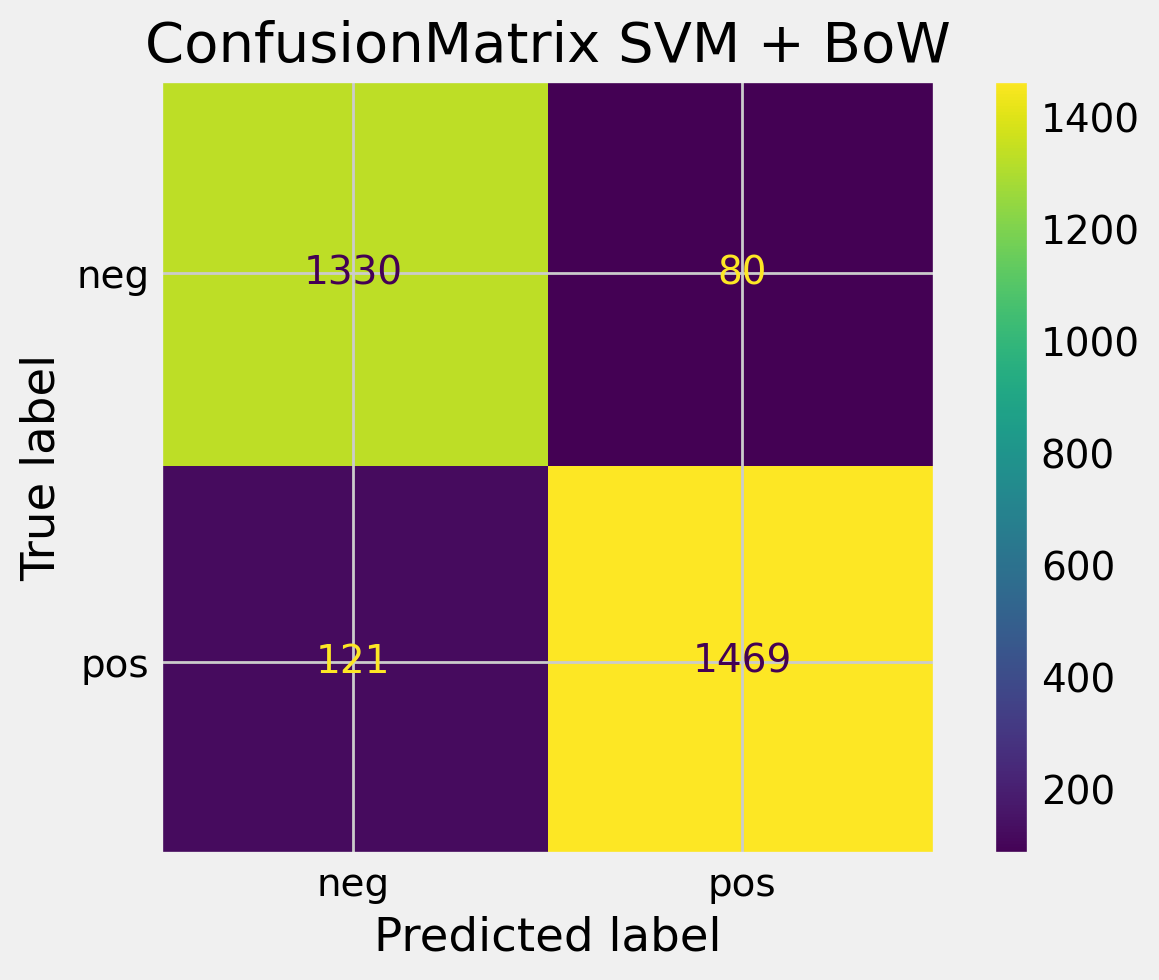

In [ ]:
cm = confusion_matrix(y_test, y_pred_SVM_count, labels=SVM_BoW.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['neg', 'pos'])
disp.plot()
plt.title('ConfusionMatrix SVM + BoW')
plt.show()


### Word2Vec

In [ ]:
otp = keras.optimizers.Adam(learning_rate=1e-5)

embedding_dim = 200
max_sequence_length = 150
vocab_size = 10000

In [ ]:
model_lstm_cnn = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
              input_length=max_sequence_length, trainable=True),
    LSTM(300, return_sequences=True, dropout=0.25, recurrent_dropout=0.1),
    Conv1D(filters=512, kernel_size=7, padding='same', activation='relu', strides=1),
    MaxPooling1D(),
    Conv1D(filters=256, kernel_size=5, activation='relu', padding='same', strides=1),
    MaxPooling1D(),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', strides=1),
    MaxPooling1D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

model_lstm_cnn.compile(loss='binary_crossentropy', optimizer=otp, metrics=['accuracy'])

In [ ]:
model_lstm_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 200)          2000000   
                                                                 
 lstm_5 (LSTM)               (None, 150, 300)          601200    
                                                                 
 conv1d_17 (Conv1D)          (None, 150, 512)          1075712   
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 75, 512)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 75, 256)           655616    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 37, 256)          0         
 g1D)                                                 

In [ ]:
history=model_lstm_cnn.fit(x_train_seq, labels_train,
                                    validation_data=(x_val_seq, labels_dev),
                                    epochs=5, batch_size=40, verbose=2)

Epoch 1/5
275/275 - 212s - loss: 0.4059 - accuracy: 0.8422 - val_loss: 0.2863 - val_accuracy: 0.8888 - 212s/epoch - 770ms/step
Epoch 2/5
275/275 - 204s - loss: 0.2802 - accuracy: 0.8912 - val_loss: 0.2476 - val_accuracy: 0.9087 - 204s/epoch - 742ms/step
Epoch 3/5
275/275 - 201s - loss: 0.2544 - accuracy: 0.9041 - val_loss: 0.2313 - val_accuracy: 0.9146 - 201s/epoch - 732ms/step
Epoch 4/5
275/275 - 201s - loss: 0.2398 - accuracy: 0.9084 - val_loss: 0.2188 - val_accuracy: 0.9232 - 201s/epoch - 731ms/step
Epoch 5/5
275/275 - 206s - loss: 0.2251 - accuracy: 0.9156 - val_loss: 0.2086 - val_accuracy: 0.9298 - 206s/epoch - 750ms/step


In [ ]:
model_lstm_cnn.save('model_lstm_cnn_3.h5')

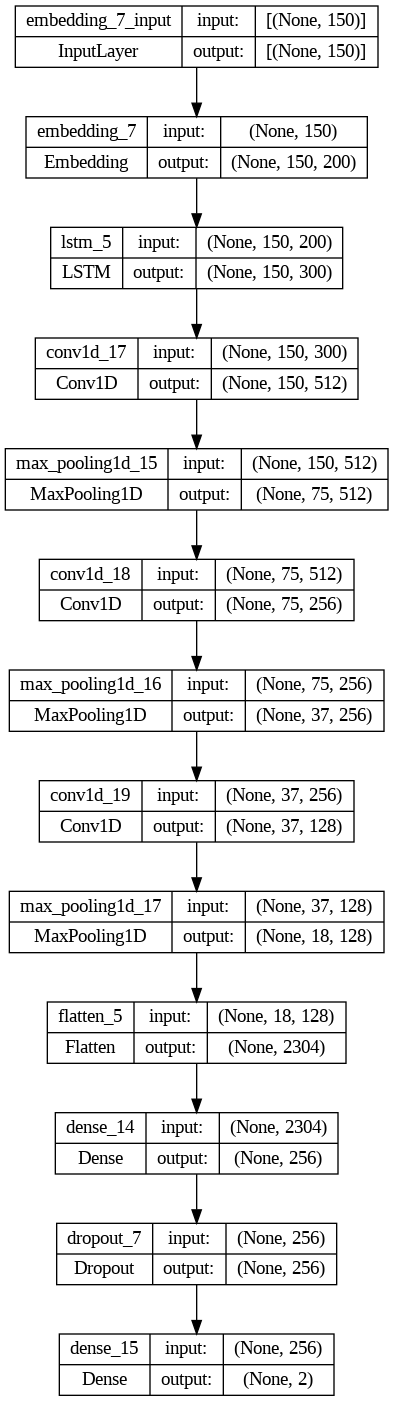

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_lstm_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
predictions = (model_lstm_cnn.predict(x_test_seq) > 0.5).astype("float32")

94/94 [==============================] - 4s 46ms/step


In [ ]:
predictions = predictions.reshape(1,-1)[0]

predictions[100:150]
arr_predictions = predictions[100:150]

for i in range(len(arr_predictions)):
  if arr_predictions[i] == 0:
    print(i , "Negative".format(i))
  else:
    print( i , "Positive".format(i))

0 Positive
1 Negative
2 Positive
3 Negative
4 Negative
5 Positive
6 Positive
7 Negative
8 Negative
9 Positive
10 Negative
11 Positive
12 Negative
13 Positive
14 Negative
15 Positive
16 Negative
17 Positive
18 Positive
19 Negative
20 Negative
21 Positive
22 Negative
23 Positive
24 Negative
25 Positive
26 Negative
27 Positive
28 Negative
29 Positive
30 Negative
31 Positive
32 Negative
33 Positive
34 Positive
35 Negative
36 Negative
37 Positive
38 Negative
39 Positive
40 Negative
41 Positive
42 Positive
43 Negative
44 Positive
45 Negative
46 Positive
47 Negative
48 Positive
49 Negative


In [ ]:
from sklearn.metrics import classification_report
y_pred = model_lstm_cnn.predict(x_test_seq, batch_size=50, verbose=2)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))

60/60 - 3s - 3s/epoch - 48ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1410
           1       0.93      0.91      0.92      1590

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



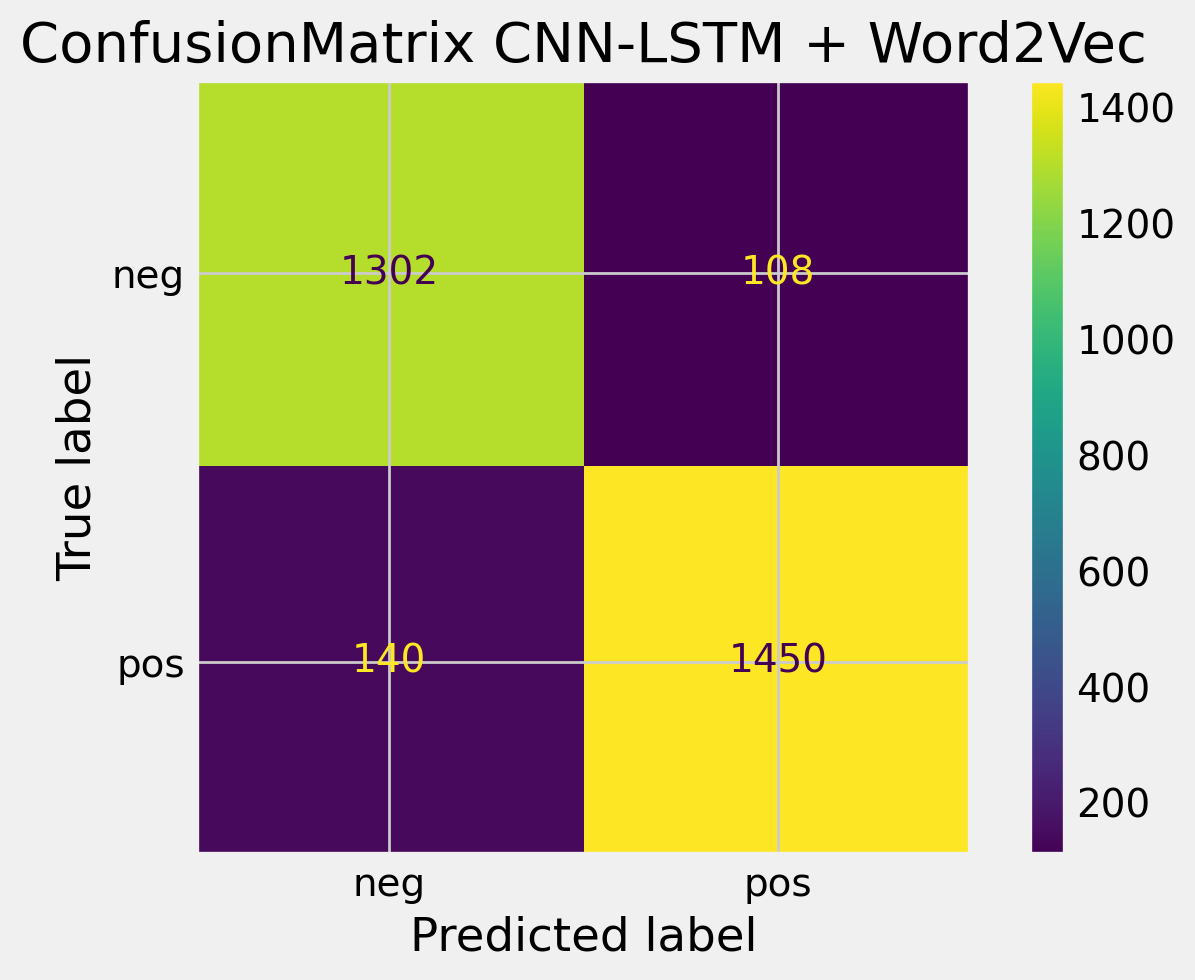

In [ ]:
cm = confusion_matrix(y_test, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['neg', 'pos'])
disp.plot()
plt.title('ConfusionMatrix CNN-LSTM + Word2Vec')
plt.show()

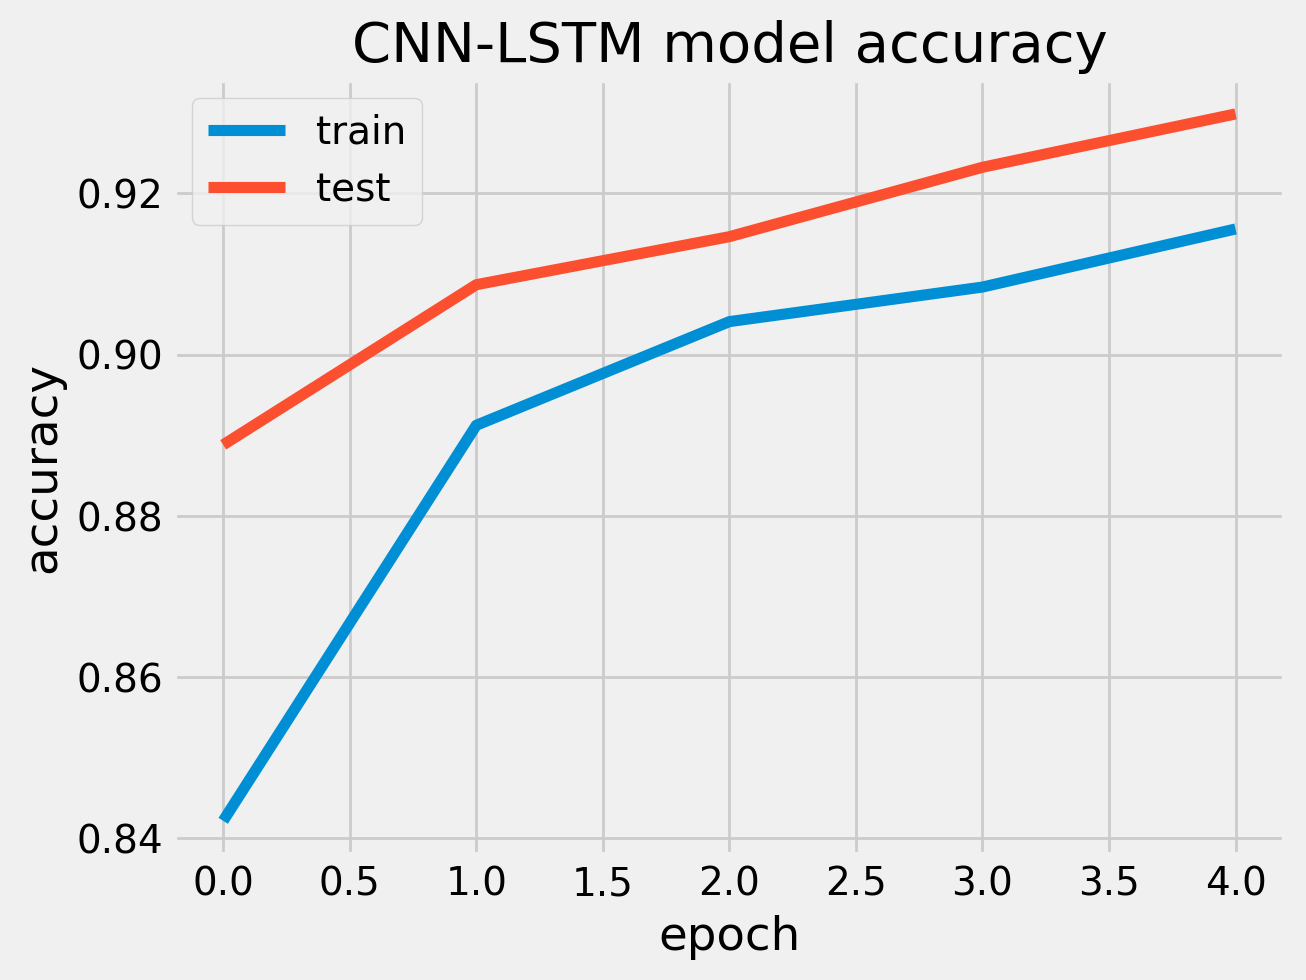

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

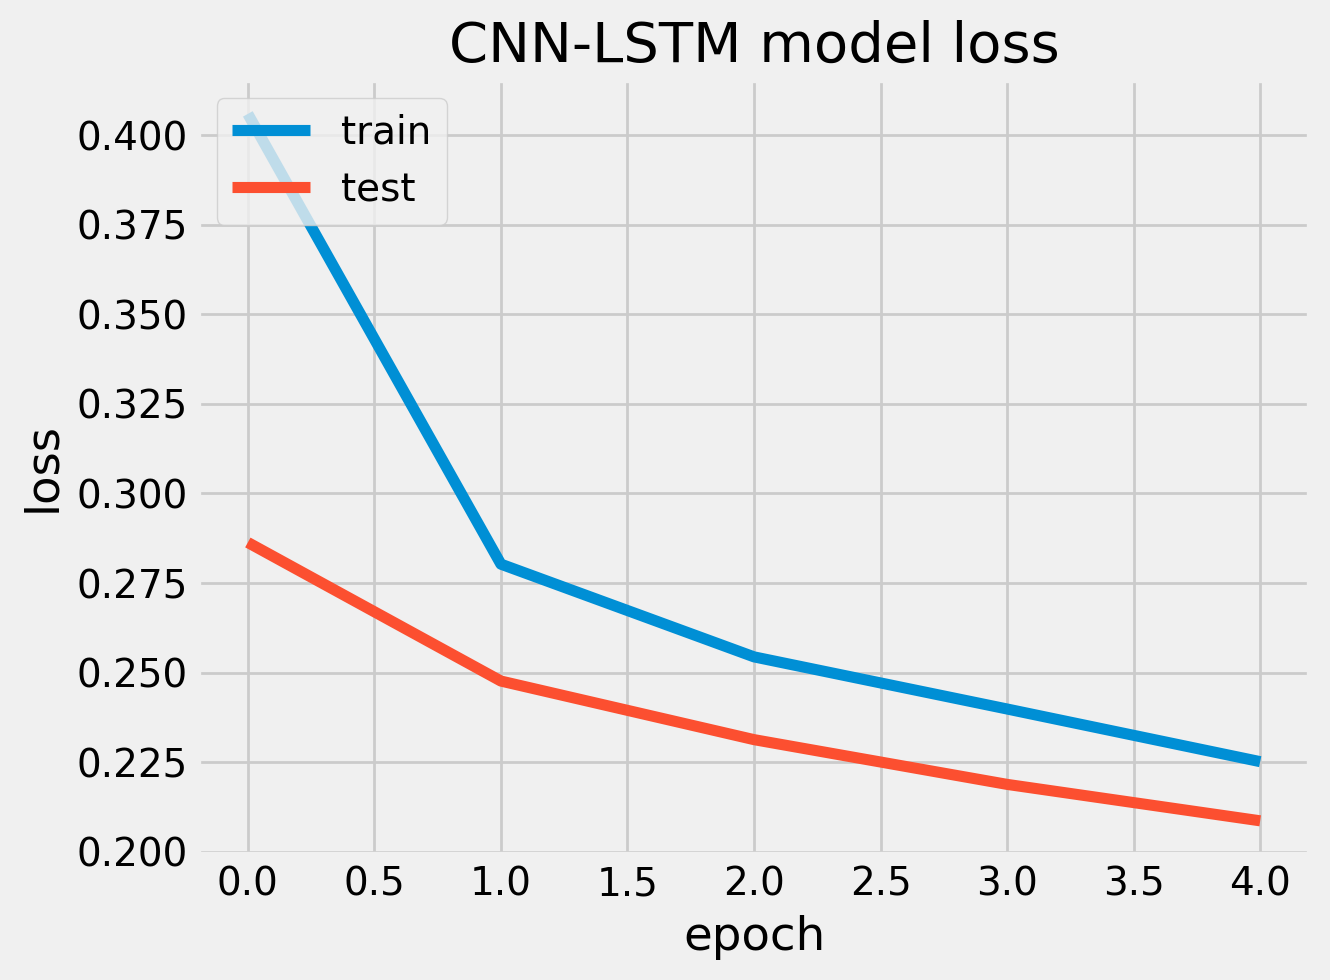

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()